In [1]:
# general packages
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

# graphing packages
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio

# content-based filtering packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# collaborative filtering packages
from sklearn.neighbors import NearestNeighbors

# matrix factorization packages
from scipy.sparse.linalg import svds

# configuration settings
np.set_printoptions(threshold=np.inf)
pio.renderers.default='notebook'
init_notebook_mode(connected=True)

# Loading Data

In [2]:
# dataframe that holds movie info
movies = pd.read_csv('ml-25m/movies.csv')
print(movies.shape)
movies.head()

(62423, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# dataframe that holds rating info
ratings = pd.read_csv('ml-25m/ratings.csv', usecols=['userId', 'movieId', 'rating'])
print(ratings.shape)
ratings.head()

(25000095, 3)


,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


# Initial Preprocessing

In [4]:
# extract the year in the parenthesis of each movie title
year_col = movies['title'].str.extract(r'\((\d{4})\)')
year_col.columns = ['year']
# append new column to hold year of movie
movies = pd.concat([movies, year_col], axis=1)
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [5]:
# Clean the title
movies['title'] = movies['title'].str.replace(r'\s\((\d{4})\)', '',regex=True)
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [6]:
# TODO: there are some duplicate movies with different genres listed for the same movie,
# merge the 2+ movies to 1 title and combine all the genres together
# 98 duplicates
movies[movies.duplicated(['title', 'year'])]

,movieId,title,genres,year
9065,26982,Men with Guns,Drama,1997
12909,64997,War of the Worlds,Action|Sci-Fi,2005
12984,65665,Hamlet,Drama,2000
13177,67459,Chaos,Crime|Drama|Horror,2005
16120,85070,Blackout,Drama,2007
...,...,...,...,...
61521,206117,The Lonely Island Presents: The Unauthorized B...,Comedy,2019
61525,206125,Lost & Found,Comedy|Drama,2018
61697,206674,Camino,Comedy,2016
61800,206925,The Plague,Documentary,2006


# Exploratory Data Analysis

In [7]:
# TODO: graph not showing in github
data = ratings['rating'].value_counts().sort_index(ascending=True)

trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / ratings.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )

layout = dict(title = 'Distribution Of {} ratings'.format(ratings.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [8]:
# TODO: graph not showing in github
data = ratings.groupby('movieId')['rating'].count().clip(upper=50)

trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))

layout = go.Layout(title = 'Distribution Of Number of Ratings Per Movie (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [9]:
# TODO: graph not showing in github
data = ratings.groupby('userId')['rating'].count().clip(upper=80)

trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 80,
                                  size = 2))

layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 80)',
                   xaxis = dict(title = 'Number of Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [10]:
title_year_group = movies.groupby(['year'])['title'].count()
title_year_group

year
1874       1
1878       1
1880       1
1883       1
1887       1
        ... 
2015    2513
2016    2488
2017    2374
2018    2034
2019     994
Name: title, Length: 135, dtype: int64

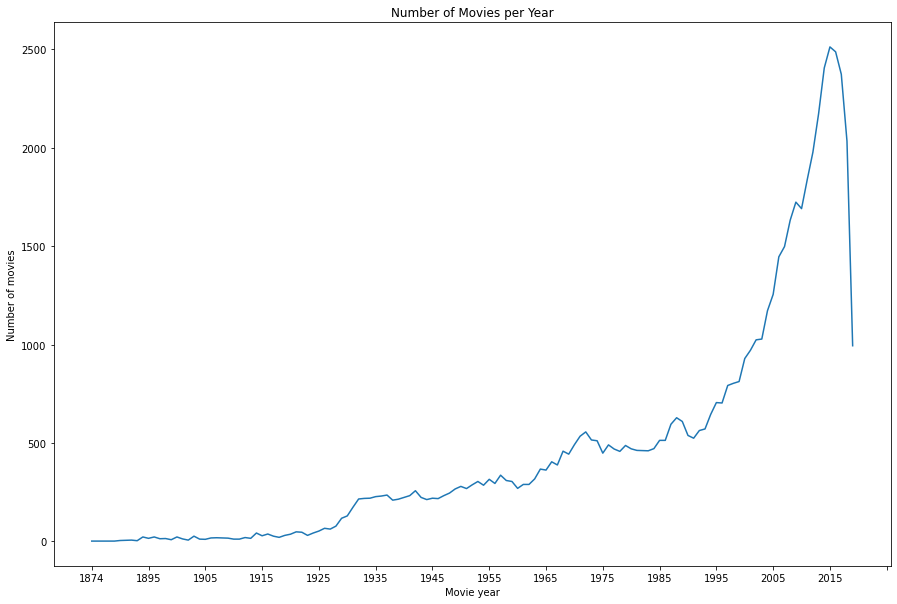

In [11]:
plt.figure(figsize=(15,10))
plt.plot(title_year_group.index, title_year_group.values)
plt.title('Number of Movies per Year')
plt.xlabel("Movie year")
plt.ylabel("Number of movies")
plt.xticks([0,10,20,30,40,50,60,70,80,90,100,110,120,130,140])
plt.show()

In [12]:
'''
# TODO: more eda?
    - ratings per genre
'''

'\n# TODO: more eda?\n    - ratings per genre\n'

# Preprocessing Dataframes

In [12]:
# combined dataframe of movies and ratings info
df = pd.merge(movies, ratings)
df

,movieId,title,genres,year,userId,rating
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,2,3.5
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,3,4.0
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,4,3.0
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,5,4.0
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,8,4.0
...,...,...,...,...,...,...
25000090,209157,We,Drama,2018,119571,1.5
25000091,209159,Window of the Soul,Documentary,2001,115835,3.0
25000092,209163,Bad Poems,Comedy|Drama,2018,6964,4.5
25000093,209169,A Girl Thing,(no genres listed),2001,119571,3.0


In [13]:
# cannot create pivot table for utility matrix since it is too big
# to store the dense version (162541 x 59047 matrix -> 71.5 GiB storage needed)
print(len(df['userId'].unique()))
print(len(df['movieId'].unique()))

162541
59047


In [14]:
# use sparse representation for utility matrix
# TODO: will likely have to use sparse algorithms to deal with sparse matrix (ex: svd from scipy instead of np)

# convert unique values to categorical
userId_c = CategoricalDtype(sorted(df['userId'].unique()), ordered=True)
movieId_c = CategoricalDtype(sorted(df['movieId'].unique()), ordered=True)

# row of pivot table is userId categories
row = df['userId'].astype(userId_c).cat.codes
# col of pivot table is movieId categories
col = df['movieId'].astype(movieId_c).cat.codes

# create sparse coordinate representation of pivot table with row being
# userId, col being movieId, and values within being the user rating on that movie
util_mat_sparse = csr_matrix((df['rating'], (row, col)))
util_mat_sparse

<162541x59047 sparse matrix of type '<class 'numpy.float64'>'
	with 25000095 stored elements in Compressed Sparse Row format>

In [15]:
print(util_mat_sparse)

  (0, 292)	5.0
  (0, 302)	3.5
  (0, 303)	5.0
  (0, 654)	5.0
  (0, 878)	3.5
  (0, 1061)	4.0
  (0, 1147)	3.5
  (0, 1186)	3.5
  (0, 1205)	5.0
  (0, 1217)	4.0
  (0, 1227)	3.5
  (0, 1591)	4.0
  (0, 1922)	2.5
  (0, 1923)	2.5
  (0, 1979)	2.5
  (0, 2071)	3.5
  (0, 2260)	4.5
  (0, 2482)	4.0
  (0, 2541)	5.0
  (0, 2600)	5.0
  (0, 2751)	4.5
  (0, 3352)	4.0
  (0, 3470)	5.0
  (0, 3845)	5.0
  (0, 4040)	5.0
  :	:
  (162540, 6318)	4.5
  (162540, 6425)	3.0
  (162540, 6668)	4.5
  (162540, 6670)	0.5
  (162540, 6809)	2.0
  (162540, 6917)	3.5
  (162540, 6965)	4.5
  (162540, 7022)	4.5
  (162540, 7028)	5.0
  (162540, 7048)	1.5
  (162540, 7068)	5.0
  (162540, 7236)	4.5
  (162540, 7897)	2.5
  (162540, 8190)	3.0
  (162540, 8246)	4.0
  (162540, 8268)	4.5
  (162540, 9591)	4.5
  (162540, 10000)	4.0
  (162540, 10448)	4.0
  (162540, 10808)	4.5
  (162540, 11359)	4.5
  (162540, 11925)	2.5
  (162540, 11972)	2.0
  (162540, 12216)	4.0
  (162540, 12819)	5.0


In [16]:
# looking at first 10 rows, 10 cols in dense format to make sure it is correct
util_mat_sparse[0:10, 0:10].todense()

matrix([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [3.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [4. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [3. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [4. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 3. ],
        [4. , 0. , 4. , 0. , 0. , 3. , 1. , 0. , 0. , 4. ],
        [0. , 5. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 5. ],
        [3.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [17]:
check_df = df.iloc[:10000000,:]
check_df.pivot_table(index = ['userId'], columns = ['movieId'], values = 'rating').fillna(0).head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,0.0,4.0,0.0,0.0,3.0,1.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> The csr representation seems to be correct

In [18]:
# sparsity measure of utility matrix
nonzero_count = util_mat_sparse.count_nonzero()
total_elements = util_mat_sparse.shape[0] * util_mat_sparse.shape[1]
sparsity = 1.0 - (nonzero_count / total_elements)
print('Number of Non-Zero Elements of Utility Matrix: ', nonzero_count)
print('Total Number of Elements of Utility Matrix:    ', total_elements)
print('Percent Sparseness of Utility Matrix:           {:.2%}'.format(sparsity))

Number of Non-Zero Elements of Utility Matrix:  25000095
Total Number of Elements of Utility Matrix:     9597558427
Percent Sparseness of Utility Matrix:           99.74%


# Content-Based Filtering
* User is recommended items based on other items similar to what the user prefers
* For this dataset, the recommendation of the item will be based on similar movie genres

In [19]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [20]:
# testing on first 3 genres
tf = TfidfVectorizer(analyzer='word')
tf.fit(movies['genres'][0:3].values)
tf.get_feature_names()

['adventure', 'animation', 'children', 'comedy', 'fantasy', 'romance']

In [21]:
movies.iloc[31]

movieId                                    32
title      Twelve Monkeys (a.k.a. 12 Monkeys)
genres                Mystery|Sci-Fi|Thriller
year                                     1995
Name: 31, dtype: object

In [22]:
movies['genres'][31].split('|')

['Mystery', 'Sci-Fi', 'Thriller']

In [23]:
tf = TfidfVectorizer(tokenizer=lambda s: s.split('|'), token_pattern=None)
tf_idf_mat = tf.fit_transform(movies['genres'].values)
# all unique genres
tf.get_feature_names()

['(no genres listed)',
 'action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'film-noir',
 'horror',
 'imax',
 'musical',
 'mystery',
 'romance',
 'sci-fi',
 'thriller',
 'war',
 'western']

In [24]:
tfidf_df = pd.DataFrame(tf_idf_mat.todense(), columns=tf.get_feature_names(), index=movies['title'])
tfidf_df.head()

,(no genres listed),action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
title,,,,,,,,,,,,,,,,,,,,
Toy Story,0.0,0.0,0.446566,0.48833,0.488084,0.277717,0.0,0.0,0.00000,0.496748,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Jumanji,0.0,0.0,0.539795,0.00000,0.589981,0.000000,0.0,0.0,0.00000,0.600454,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Grumpier Old Men,0.0,0.0,0.000000,0.00000,0.000000,0.598464,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.801149,0.0,0.0,0.0,0.0
Waiting to Exhale,0.0,0.0,0.000000,0.00000,0.000000,0.537355,0.0,0.0,0.44022,0.000000,0.0,0.0,0.0,0.0,0.0,0.719344,0.0,0.0,0.0,0.0
Father of the Bride Part II,0.0,0.0,0.000000,0.00000,0.000000,1.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [25]:
# Vector similarity using cosine similarity
# TODO: change to sparse representation since too big (29GB)
cosine_sim = cosine_similarity(tfidf_df)

In [26]:
cos_sim_df = pd.DataFrame(cosine_sim, index=movies['title'], columns=movies['title'])
cos_sim_df.shape

(62423, 62423)

In [27]:
cos_sim_df.head()

title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Liberté,The Carpet of Horror,Mao Zedong 1949,Happy Flight,Santosh Subramaniam,We,Window of the Soul,Bad Poems,A Girl Thing,Women of Devil's Island
title,,,,,,,,,,,,,,,,,,,,,
Toy Story,1.000000,0.827289,0.166204,0.149233,0.277717,0.0,0.166204,0.661549,0.0,0.290807,...,0.00000,0.0,0.0,0.214830,0.128904,0.00000,0.0,0.214830,0.0,0.317769
Jumanji,0.827289,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.799660,0.0,0.351518,...,0.00000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.384109
Grumpier Old Men,0.166204,0.000000,1.000000,0.897890,0.598464,0.0,1.000000,0.000000,0.0,0.000000,...,0.00000,0.0,0.0,0.462947,0.775575,0.00000,0.0,0.462947,0.0,0.000000
Waiting to Exhale,0.149233,0.000000,0.897890,1.000000,0.537355,0.0,0.897890,0.000000,0.0,0.000000,...,0.44022,0.0,0.0,0.694654,0.696381,0.44022,0.0,0.694654,0.0,0.159596
Father of the Bride Part II,0.277717,0.000000,0.598464,0.537355,1.000000,0.0,0.598464,0.000000,0.0,0.000000,...,0.00000,0.0,0.0,0.773558,0.464154,0.00000,0.0,0.773558,0.0,0.000000


In [28]:
def genre_recommendations(index, sim_df, items, k):

    ix = sim_df.loc[:,index].to_numpy().argpartition(range(-1,-k,-1))
    closest = sim_df.columns[ix[-1:-(k+2):-1]]
    closest = closest.drop(index, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

In [29]:
#Testing genre recommendation
movies[movies.title.eq('Toy Story')]

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995


In [30]:
genre_recommendations('Toy Story', cos_sim_df, movies[['title', 'genres']], 15)

,title,genres
0,Frozen II,Adventure|Animation|Children|Comedy|Fantasy
1,Puss in Book: Trapped in an Epic Tale,Adventure|Animation|Children|Comedy|Fantasy
2,"Emperor's New Groove, The",Adventure|Animation|Children|Comedy|Fantasy
3,Penguin Highway,Adventure|Animation|Children|Comedy|Fantasy
4,"Wild, The",Adventure|Animation|Children|Comedy|Fantasy
5,"Monsters, Inc.",Adventure|Animation|Children|Comedy|Fantasy
6,The Magic Crystal,Adventure|Animation|Children|Comedy|Fantasy
7,Turbo,Adventure|Animation|Children|Comedy|Fantasy
8,Aladdin,Adventure|Animation|Children|Comedy|Musical
9,Aladdin,Adventure|Animation|Children|Comedy|Fantasy


In [31]:
#Let's try some more examples
movies[movies.title.eq('Saving Private Ryan')]

,movieId,title,genres,year
1939,2028,Saving Private Ryan,Action|Drama|War,1998


In [32]:
genre_recommendations('Saving Private Ryan', cos_sim_df, movies[['title', 'genres']], 15)

,title,genres
0,The Camp on Blood Island,Action|Drama|War
1,The Boys from St. Petri,Action|Drama|War
2,King David,Action|Drama|War
3,"Lost Battalion, The",Action|Drama|War
4,Danger Close: The Battle of Long Tan,Action|Drama|War
5,The Eagle and the Hawk,Action|Drama|War
6,5 Days of War,Action|Drama|War
7,Ip Man,Action|Drama|War
8,"Water Diviner, The",Action|Drama|War
9,Sky Hunter,Action|Drama|War


In [33]:
movies[movies.title.eq('Event Horizon')]

,movieId,title,genres,year
1533,1590,Event Horizon,Horror|Sci-Fi|Thriller,1997


In [34]:
genre_recommendations('Event Horizon', cos_sim_df, movies[['title', 'genres']], 20)

,title,genres
0,Crawl or Die,Horror|Sci-Fi|Thriller
1,Altergeist,Horror|Sci-Fi|Thriller
2,Night of the Lepus,Horror|Sci-Fi|Thriller
3,Breeders,Horror|Sci-Fi
4,Breeders,Horror|Sci-Fi|Thriller
5,Lost Voyage,Horror|Sci-Fi|Thriller
6,Patrick,Horror|Sci-Fi|Thriller
7,Patrick,Horror|Sci-Fi|Thriller
8,Patrick,Children|Comedy
9,Flatliners,Horror|Sci-Fi|Thriller


In [35]:
movies[movies.title.eq('Strange Days')]

,movieId,title,genres,year
196,198,Strange Days,Action|Crime|Drama|Mystery|Sci-Fi|Thriller,1995


In [36]:
genre_recommendations('Strange Days', cos_sim_df, movies[['title', 'genres']], 20)

,title,genres
0,"X-Files: Fight the Future, The",Action|Crime|Mystery|Sci-Fi|Thriller
1,Minority Report,Action|Crime|Mystery|Sci-Fi|Thriller
2,Talking to Heaven,Crime|Drama|Mystery|Sci-Fi|Thriller
3,"Groundstar Conspiracy, The",Action|Crime|Mystery|Romance|Sci-Fi|Thriller
4,Knowing,Action|Drama|Mystery|Sci-Fi|Thriller
5,Source Code,Action|Drama|Mystery|Sci-Fi|Thriller
6,S. Darko (S. Darko: A Donnie Darko Tale),Crime|Mystery|Sci-Fi|Thriller
7,Third Man Out,Action|Crime|Drama|Mystery|Thriller
8,"Girl Who Played with Fire, The (Flickan som le...",Action|Crime|Drama|Mystery|Thriller
9,Man on Fire,Action|Crime|Drama|Mystery|Thriller


# Collaborative Filtering
* User is recommended items that people with similar preferences liked in the past
* For this dataset, the recommendation of the item will be based on the utility matrix

In [ ]:
check_df
pivot2 = check_df.pivot_table(index = ['title'], columns = ['userId'], values = 'rating').fillna(0)

In [ ]:
pivot2.head(10)

In [ ]:
collab_mat = csr_matrix(pivot2.values)
collab_mat

In [ ]:
#creating knn model. I based the values off the article, but we can play around with them
model = NearestNeighbors(n_neighbors=7,algorithm='brute', metric='cosine')
model.fit(collab_mat)

In [ ]:
distances,suggestions = model.kneighbors(pivot2.iloc[10,:].values.reshape(1,-1))

In [ ]:
distances

In [ ]:
suggestions

In [ ]:
for i in range(len(suggestions)):
    print(pivot2.index[suggestions[i]])

In [ ]:
def collabrec(movie_name):
    movie_id=pivot2.index.get_loc(movie_name)
    distances,suggestions = model.kneighbors(pivot2.iloc[movie_id,:].values.reshape(1,-1))

    for i in range(len(suggestions)):
        print(pivot2.index[suggestions[i]])

# Matrix Factorization Using SVD
* SVD $ (A = U \Sigma V^T) $
* For this dataset,
  * $ A $ is the utility matrix
  * $ U $ is the user features matrix, representing how much each user likes each feature
  * $ \Sigma $ is the diagonal matrix of weights (singular values)
  * $ V^T $ is the movie features matrix, representing how relevant each feature is to each movie

In [20]:
U, Sig, Vt = svds(util_mat_sparse[0:10000, 0:10000], k=30)
Sig = np.diag(Sig)
U.shape, Sig.shape, Vt.shape

((10000, 30), (30, 30), (30, 10000))

In [21]:
U_sparse = csr_matrix(U)
Sig_sparse = csr_matrix(Sig)
Vt_sparse = csr_matrix(Vt)
U_sparse, Sig_sparse, Vt_sparse

(<10000x30 sparse matrix of type '<class 'numpy.float64'>'
 	with 300000 stored elements in Compressed Sparse Row format>,
 <30x30 sparse matrix of type '<class 'numpy.float64'>'
 	with 30 stored elements in Compressed Sparse Row format>,
 <30x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 277710 stored elements in Compressed Sparse Row format>)

In [22]:
svd_recon = np.dot(np.dot(U_sparse, Sig_sparse), Vt_sparse)
preds_df = pd.DataFrame(svd_recon.todense(), columns=np.arange(1, 10000+1))
preds_df

,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,-0.056736,0.017745,-0.075142,-0.036847,-0.080559,0.028580,-0.060459,-0.058364,0.042198,0.500765,...,0.031238,0.040292,-0.000380,0.016011,0.002393,0.0,0.0,0.023349,0.009459,0.006768
1,3.535286,0.543653,0.093374,-0.060358,-0.055055,0.567632,0.065097,0.030736,-0.056777,0.553806,...,0.013008,-0.038705,0.000414,0.007416,0.000764,0.0,0.0,-0.006753,0.008801,0.010320
2,1.219967,0.640903,-0.567243,-0.141419,0.004750,0.857690,0.078382,-0.083821,-0.170736,0.229897,...,0.058403,0.107640,0.002712,0.003348,0.000981,0.0,0.0,0.121711,0.009005,-0.008680
3,2.487228,0.089812,-0.102042,-0.065660,-0.031277,0.225287,-0.021292,-0.042154,-0.015095,0.215832,...,-0.006490,-0.002670,-0.001593,-0.003537,0.003263,0.0,0.0,0.090939,0.002289,0.003393
4,3.734360,0.925714,1.305075,0.166424,1.182152,1.429134,1.128122,0.076438,0.426592,1.281804,...,0.024443,-0.008037,-0.000638,0.006478,0.001951,0.0,0.0,0.000915,0.027999,0.009552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.482253,1.425154,0.236094,0.156438,0.353978,0.548615,0.517501,0.197961,-0.027796,0.650375,...,0.024732,-0.014680,0.000216,0.017577,-0.001573,0.0,0.0,-0.003285,0.022728,0.008787
9996,2.056211,-0.279832,0.043368,0.038768,0.047219,0.815028,-0.174163,-0.105039,-0.030714,0.302926,...,0.014495,-0.005455,0.000084,0.001030,0.002507,0.0,0.0,0.006230,-0.001187,0.009961
9997,1.104865,0.498342,-0.093537,-0.039849,0.007700,3.490960,0.406387,-0.043150,0.062982,1.061071,...,-0.008542,0.059310,0.001019,0.007103,-0.009523,0.0,0.0,0.026502,-0.018133,-0.001919
9998,1.307811,0.166621,0.218975,-0.062363,0.063133,2.097753,0.205652,-0.008774,0.351658,2.049129,...,-0.027827,0.003059,-0.000507,-0.005130,-0.001769,0.0,0.0,-0.022944,-0.021503,-0.000761


In [23]:
def svd_recommendation(userId):
    # get index of similar neighbors
    neighbors = cosine_similarity(preds_df)
    neighbors = np.argsort(neighbors.T)
    
    # skip first smallest distance since it's itself
    top_five_neigh = np.flip(neighbors[userId-1])[1:10]
    
    # get the recommendations
    svd_recoms = movies[movies['movieId'].isin(top_five_neigh)]
    
    return svd_recoms

In [24]:
svd_recommendation(userId=1)

,movieId,title,genres,year
1171,1201,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western,1966
3897,4001,Code of Silence,Action,1985
4399,4504,Feds,Comedy,1988
4584,4689,"Cat o' Nine Tails, The (Gatto a nove code, Il)",Mystery|Thriller,1971
5243,5351,Warm Water Under a Red Bridge (Akai hashi no s...,Comedy|Drama,2001
5272,5380,"Importance of Being Earnest, The",Comedy|Drama|Romance,2002


In [26]:
svd_recommendation(userId=20)

,movieId,title,genres,year
719,734,Getting Away With Murder,Comedy,1996
746,762,Striptease,Comedy|Crime,1996
3293,3388,Harry and the Hendersons,Children|Comedy,1987
3402,3500,Mr. Saturday Night,Comedy|Drama,1992
6639,6762,Yossi & Jagger,Drama|Romance,2002
7546,7936,Shame (Skammen),Drama|War,1968


In [27]:
svd_recommendation(userId=100)

,movieId,title,genres,year
1472,1524,"Turning, The",Drama,1992
4405,4510,Heartbreak Hotel,Comedy,1988
4674,4780,Liam,Drama,2000
5900,6012,"Guy Thing, A",Comedy|Romance,2003
6484,6607,"Red Pony, The",Drama,1949
6516,6639,Wait Until Dark,Drama|Thriller,1967
7544,7934,Zelig,Comedy,1983


# Other TODOS
- In depth explanations (dataset, sparsity, filtering methods, etc)